### Importing the  OASIS 2 Dataset: Longitudinal Demographics

In [314]:
import pandas as pd

data = pd.read_csv("~/code/mkvph0ch/memobrain/raw_data/OASIS2/oasis_longitudinal_demographics.csv")

data[:10]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


### Data cleaning
We check if there are any missing values in the dataset:

In [3]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

We create the prep_data function, that drops unneeded columns:
- 'MR Delay', 'Group' and 'Visit' (this information does not apply to the analysis)
- 'Hand' (all patients are right handed)
- 'Subject ID', 'MRI ID' (they are just identification strings)

It fills empty values with the median in the case of 'SES' and 'MMSE' features. (Categorical values)

It also transforms the target column 'CDR' into binary class, dividing into Demented (some level) and Non Demented.

In [293]:
#def prep_data(data):
    #data=data.drop(columns=['MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'Hand'])
    #data['SES'].fillna(value=int(data.SES.median()), inplace=True)
    #data['MMSE'].fillna(value=int(data.MMSE.median()), inplace=True)
    #data["CDR"]=data["CDR"].apply(lambda x: 1 if x>0 else 0)
    #data["M/F"]=data["M/F"].apply(lambda x: 1 if x=='M' else 0)  
    #return data

Then we split the data into X features and the y target.

In [334]:
from sklearn.preprocessing import LabelEncoder

X=data.drop(columns=['CDR', 'MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'Hand'])
y=data['CDR'].apply(lambda x: 1 if x>0 else 0)
X

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,M,87,14,2.0,27.0,1987,0.696,0.883
1,M,88,14,2.0,30.0,2004,0.681,0.876
2,M,75,12,NaN,23.0,1678,0.736,1.046
3,M,76,12,NaN,28.0,1738,0.713,1.010
4,M,80,12,NaN,22.0,1698,0.701,1.034
...,...,...,...,...,...,...,...,...
368,M,82,16,1.0,28.0,1693,0.694,1.037
369,M,86,16,1.0,26.0,1688,0.675,1.040
370,F,61,13,2.0,30.0,1319,0.801,1.331
371,F,63,13,2.0,30.0,1327,0.796,1.323


EDUC: Level of Education (6 to 23)

SES: Socioeconomic Status (1 to 5)

MMSE: Mini-Mental State Examination (4 to 30)

eTIV: Estimated total intracranial volume (mm3)

nWBV: Normalized whole brain volume

ASF: Atlas scaling factor

<AxesSubplot:>

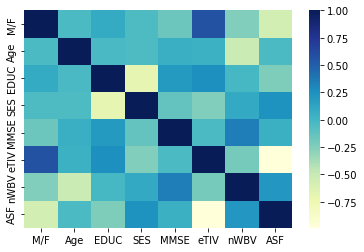

In [6]:
import seaborn as sns

corr = X.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

### Pipeline
We create a pipeline with all the transformations that will be applied to the data set, including scaling and encoding.

In [335]:
from sklearn import set_config; set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

pipe1 = make_pipeline(SimpleImputer(strategy="median"), RobustScaler())

preproc = ColumnTransformer([
    ('encoder', OneHotEncoder(drop = "if_binary"), ["M/F"]),
    ('imp_scaler', pipe1, ['MMSE']),
    ('imputer', SimpleImputer(strategy="median"), ['SES']),
    ('s_scaler', StandardScaler(), ['Age']),
    ('m_scaler', MinMaxScaler(), ['EDUC']),
    ('r_scaler', RobustScaler(), ['eTIV'])],
    remainder='passthrough')

preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', OneHotEncoder(drop='if_binary'),
                                 ['M/F']),
                                ('imp_scaler',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['MMSE']),
                                ('imputer', SimpleImputer(strategy='median'),
                                 ['SES']),
                                ('s_scaler', StandardScaler(), ['Age']),
                                ('m_scaler', MinMaxScaler(), ['EDUC']),
                                ('r_scaler', RobustScaler(), ['eTIV'])])

We now split the data into train and test set.

In [337]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [338]:
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)
X_train_piped=pd.DataFrame(preproc.fit_transform(X_train), columns = preproc.get_feature_names_out())
X_test_pined=pd.DataFrame(preproc.transform(X_test), columns = preproc.get_feature_names_out())

\
Renaming the column labels that were modified while applying the pipeline.

In [339]:
X_train_piped = X_train_piped.rename(columns={"s_scaler__Age": "Age",
                              "m_scaler__EDUC": "Educ",
                              "r_scaler__eTIV": "eTIV",
                              "imp_scaler__MMSE": "MMSE",
                              "encoder__M/F_M": "M/F",
                              "imputer__SES": "SES",
                              "remainder__nWBV": "nWBV",
                              "remainder__ASF": "ASF"})

X_train_piped = X_train_piped[["M/F", "Age", "Educ", "SES", "MMSE", "eTIV", "nWBV", "ASF"]]
X_train_piped

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
0,1.0,-0.746814,0.588235,1.0,-4.000000,0.350806,0.685,1.123
1,1.0,0.054575,0.705882,1.0,-1.333333,0.520161,0.781,1.094
2,1.0,-1.281072,0.352941,4.0,0.333333,-0.141129,0.727,1.219
3,0.0,-1.414637,0.352941,3.0,0.333333,-0.112903,0.769,1.213
4,0.0,-0.746814,0.470588,4.0,-1.000000,0.217742,0.788,1.147
...,...,...,...,...,...,...,...,...
274,0.0,-0.212555,0.411765,4.0,0.000000,-0.508065,0.778,1.301
275,1.0,-0.613249,0.352941,4.0,-4.000000,0.032258,0.695,1.184
276,0.0,0.722398,0.705882,1.0,0.000000,-0.133065,0.644,1.217
277,1.0,1.657352,0.588235,2.0,0.333333,-0.270161,0.679,1.246


Exporting the transformed dataset to evaluate in model of Oasis1 and viceversa.

In [22]:
frames=[oasis2_scaled, y]
oasis2 = pd.concat(frames, axis =1)
oasis2

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF,CDR
0,1.0,1.308738,0.470588,2.0,-0.666667,2.154167,0.696,0.883,0
1,1.0,1.439787,0.470588,2.0,0.333333,2.225000,0.681,0.876,0
2,1.0,-0.263856,0.352941,2.0,-2.000000,0.866667,0.736,1.046,1
3,1.0,-0.132806,0.352941,2.0,-0.333333,1.116667,0.713,1.010,1
4,1.0,0.391392,0.352941,2.0,-2.333333,0.950000,0.701,1.034,1
...,...,...,...,...,...,...,...,...,...
368,1.0,0.653491,0.588235,1.0,-0.333333,0.929167,0.694,1.037,1
369,1.0,1.177688,0.588235,1.0,-1.000000,0.908333,0.675,1.040,1
370,0.0,-2.098548,0.411765,2.0,0.333333,-0.629167,0.801,1.331,0
371,0.0,-1.836449,0.411765,2.0,0.333333,-0.595833,0.796,1.323,0


### Choosing the right estimator

We will look now for the right estimator to solve this machine learning problem. Since we have a dataset size between 50 and 100k samples, and target is categorical, we will start with the Linear Support Vector Classification (SVC) estimator.



We will do GridSearch to find the best parameters on each model, scoring on "recall". This because we want to identify all the positive samples, in this case, the patients with dementia.

#### SVC

##### Linear SVC 

In [206]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

model_svc_linear = LinearSVC(max_iter=100000)

parameters = {'C': [0.1, 1, 5, 50, 100, 500]}

gridsearch1 = GridSearchCV(model_svc_linear,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=100000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 50, 100, 500]}, scoring='recall')

In [209]:
gridsearch1.best_params_

{'C': 100}

In [210]:
gridsearch1.best_score_

0.7070000000000001

In [211]:
model_lsvc_best = LinearSVC(C= 1, max_iter=10000)
model_lsvc_best.fit(X_train, y_train)

LinearSVC(C=1, max_iter=10000)

Now we will predict the target:

In [212]:
y_pred1 = model_lsvc_best.predict(X_test)

In [214]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred1)

0.7727272727272727

##### SVC: Poly

In [166]:
from sklearn.svm import SVC

model_svc_poly = SVC(kernel="poly")

parameters = {'C': [1, 10, 100, 1000, 10000, 100000],
              'gamma': [0.01, 0.1, 0.2, 0.5, 0.75, 1]}

gridsearch2 = GridSearchCV(model_svc_poly,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000, 100000],
                         'gamma': [0.01, 0.1, 0.2, 0.5, 0.75, 1]},
             scoring='recall')

In [167]:
gridsearch2.best_params_

{'C': 1000, 'gamma': 0.5}

In [168]:
gridsearch2.best_score_

0.773

In [170]:
model_svc_poly_best = SVC(kernel="poly", C= 1000, gamma=0.5)
model_svc_poly_best.fit(X_train, y_train)

SVC(C=1000, gamma=0.5, kernel='poly')

In [171]:
y_pred2 = model_svc_poly_best.predict(X_test)

In [172]:
recall_score(y_test, y_pred2)

0.75

##### SVC: Rbf

In [231]:
from sklearn.svm import SVC

model_svc_rbf = SVC(kernel= 'rbf')

parameters = {'C': [1, 10, 50, 100, 500, 1000, 5000],
              'gamma': [0.01, 0.1, 0.2, 0.5, 0.75, 1]}

gridsearch3 = GridSearchCV(model_svc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 1000, 5000],
                         'gamma': [0.01, 0.1, 0.2, 0.5, 0.75, 1]},
             scoring='recall')

In [232]:
gridsearch3.best_params_

{'C': 5000, 'gamma': 0.5}

In [225]:
gridsearch3.best_score_

0.7726666666666667

In [233]:
model_svc_rbf_best = SVC(kernel="rbf", C= 5000, gamma=0.5)
model_svc_rbf_best.fit(X_train, y_train)

SVC(C=5000, gamma=0.5)

In [234]:
y_pred3 = model_svc_rbf_best.predict(X_test)

In [235]:
recall_score(y_test, y_pred3)

0.8863636363636364

#### KNeighbors Classifier

In [179]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

parameters = {'n_neighbors': range(1,10)}

gridsearch4 = GridSearchCV(knc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

In [180]:
gridsearch4.best_params_

{'n_neighbors': 1}

In [181]:
gridsearch4.best_score_

0.7556666666666667

In [182]:
model_knc_best = KNeighborsClassifier(n_neighbors= 1)
model_knc_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [183]:
y_pred4 = model_knc_best.predict(X_test)

In [184]:
recall_score(y_test, y_pred4)

0.8636363636363636

#### Decision Tree

We will create now a Decision Tree, to break down the data through binary decisions.

In [215]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10)}
gridsearch4 = GridSearchCV(DecisionTreeClassifier(),
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             scoring='recall')

In [216]:
gridsearch4.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [217]:
gridsearch4.best_score_

0.7733333333333333

In [218]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', max_depth=7, min_samples_leaf= 3, min_samples_split= 7)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=7)

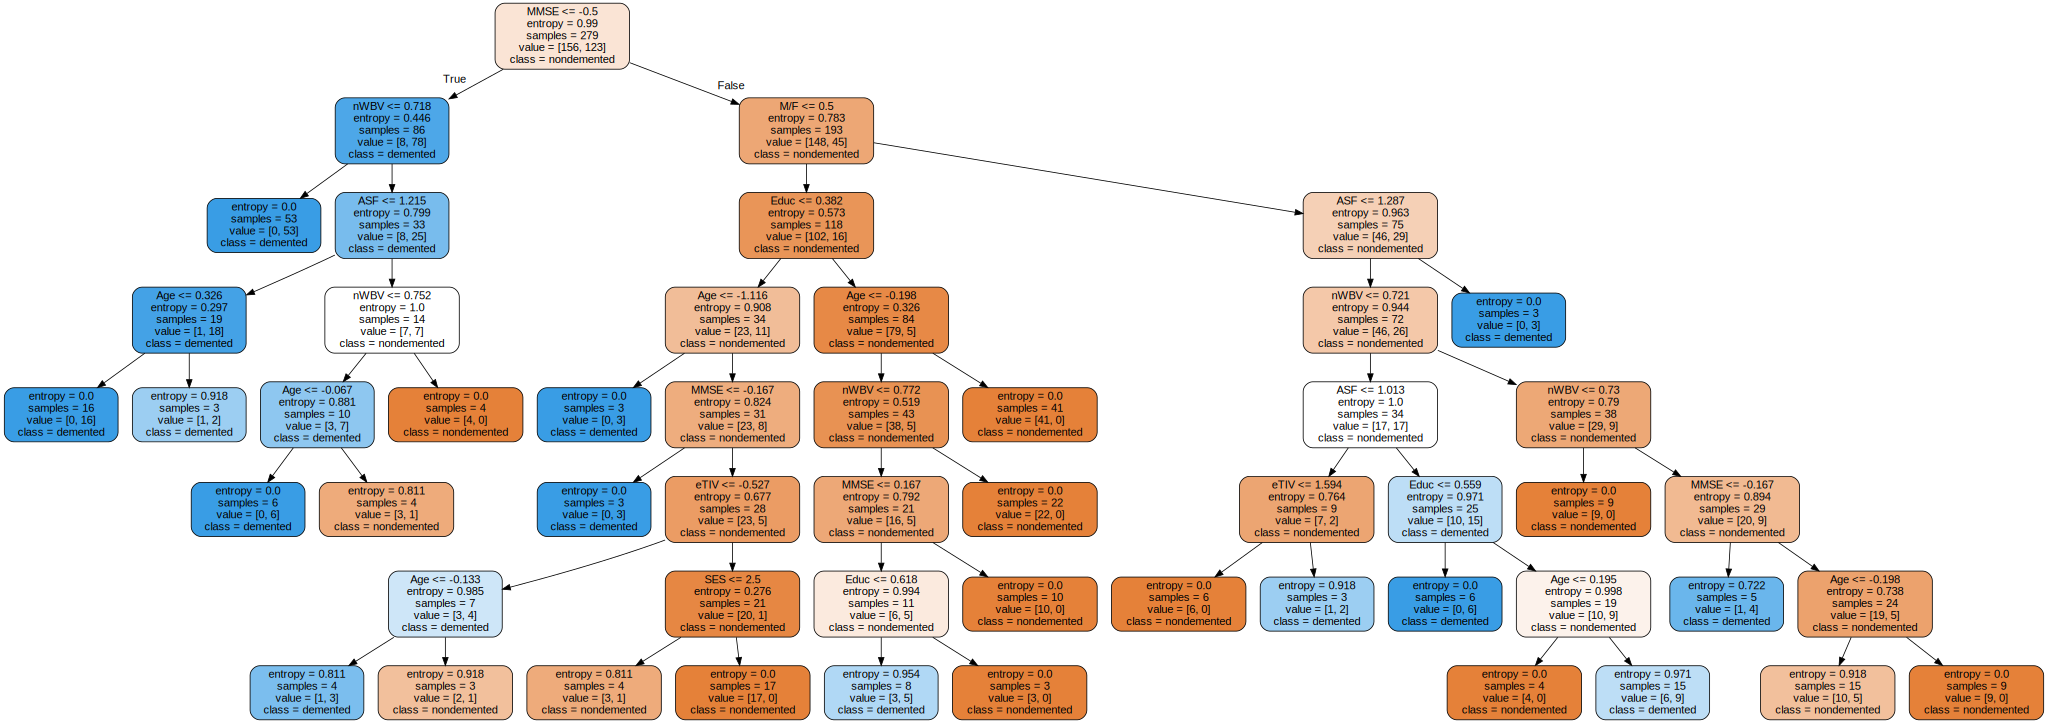

In [219]:
import graphviz

from sklearn.tree import export_graphviz
export_graphviz(tree_clf, out_file="dt.dot", 
                feature_names=X_train.columns,
                class_names=['nondemented','demented'], 
                rounded=True, filled=True)

with open("dt.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [220]:
y_pred5 = tree_clf.predict(X_test)

In [221]:
recall_score(y_test, y_pred5)

0.7272727272727273

In [268]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()

parameters = {'n_estimators': [100, 200, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5,6,7,8],
              'criterion' :['gini', 'entropy']}

gridsearch6 = GridSearchCV(rfc, parameters, cv= 5, n_jobs=-1, scoring="recall")
gridsearch6.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [269]:
gridsearch6.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [270]:
gridsearch6.best_score_

0.7483333333333333

In [271]:
rfc_best = RandomForestClassifier(n_estimators= 100, max_features= 'sqrt', max_depth= 8, criterion= 'entropy')
rfc_best.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt')

In [274]:
y_pred6 = rfc_best.predict(X_test)

In [275]:
recall_score(y_test, y_pred6)

0.7954545454545454

We have that the best estimator is the SVC with rbf kernel. We are going to evaluate our model now in the OASIS1 dataset and viceversa.

In [ ]:
frames=[oasis2_scaled, y]
oasis2 = pd.concat(frames, axis =1)
oasis2.to_csv(r'~/code/mkvph0ch/memobrain/notebooks/oasis2.csv')

In [277]:
oasis1 = pd.read_csv("~/code/mkvph0ch/memobrain/raw_data/OASIS1/preprocessed_oasis1.csv")
oasis1

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF,CDR
0,0,0.137193,0.25,3,0.00,-0.515,0.743,1.306,0
1,0,-1.437530,0.75,1,0.00,-1.500,0.810,1.531,0
2,0,0.054313,0.75,3,-0.50,0.035,0.708,1.207,1
3,1,0.137193,1.00,2,0.25,0.945,0.689,1.073,0
4,0,-1.686170,0.50,2,0.25,-0.630,0.827,1.329,0
...,...,...,...,...,...,...,...,...,...
230,0,-0.194328,0.00,4,0.00,-0.760,0.748,1.355,1
231,0,0.054313,0.50,2,-1.50,0.445,0.730,1.142,1
232,0,-0.940249,0.25,4,-0.25,-0.465,0.825,1.297,0
233,1,-0.940249,1.00,2,0.25,0.950,0.780,1.072,0


In [278]:
X1=oasis1.drop(columns=['CDR'])
y1=oasis1['CDR']

In [279]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state=42)

In [280]:
model_svc_rbf_best = SVC(kernel="rbf", C= 5000, gamma=0.5)
model_svc_rbf_best.fit(X_train, y_train)

SVC(C=5000, gamma=0.5)

In [281]:
y_pred_oasis1 = model_svc_rbf_best.predict(X_test1)

In [282]:
recall_score(y_test1, y_pred_oasis1)

0.7391304347826086